https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [69]:
import xgboost
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import numpy as np

In [2]:
features=pd.read_csv('features.csv')

In [3]:
features.head()

,Unnamed: 0,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,travel_time,date_of_year,year,mo,...,day_of_week,weekday,day_binned,day_hour,time_binned,day_number,day_cosine,day_sine,time_cosine,time_sine
0,0,2016-01-18 03:25:25,40.731525,-73.988670,40.760036,-73.984856,626,2016-01-18,2016,1,...,1.0,1.0,0.142857,3.0,0.125000,0.160714,0.532032,0.846724,0.707107,0.707107
1,1,2016-01-25 17:09:52,40.713608,-74.013718,40.765598,-73.980713,1192,2016-01-25,2016,1,...,1.0,1.0,0.142857,17.0,0.708333,0.244048,0.037391,0.999301,-0.258819,-0.965926
2,2,2016-01-05 00:17:41,40.773960,-73.874435,40.766693,-73.955414,842,2016-01-05,2016,1,...,2.0,1.0,0.285714,0.0,0.000000,0.285714,-0.222521,0.974928,1.000000,0.000000
3,3,2016-01-01 07:44:33,40.749718,-73.991570,40.768169,-73.912483,1054,2016-01-01,2016,1,...,5.0,1.0,0.714286,7.0,0.291667,0.755952,0.037391,-0.999301,-0.258819,0.965926
4,4,2016-05-29 14:34:21,40.762730,-73.974174,40.779640,-73.961823,538,2016-05-29,2016,5,...,0.0,0.0,0.000000,14.0,0.583333,0.083333,0.866025,0.500000,-0.866025,-0.500000


In [127]:
features_list=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','weekday','distance_in_km','temp','wdsp','prcp','sndp','day_number','day_cosine','day_sine','time_cosine','time_sine']
y=features['travel_time']
X=features[features_list]

In [5]:
kf = KFold(n_splits=2)
kf.get_n_splits(X)
print(kf)  
KFold(n_splits=2, random_state=2, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.loc[train_index], X.loc[test_index]
    ytrain, ytest = y.loc[train_index], y.loc[test_index]

KFold(n_splits=2, random_state=None, shuffle=False)
TRAIN: [1421262 1421263 1421264 ... 2842521 2842522 2842523] TEST: [      0       1       2 ... 1421259 1421260 1421261]
TRAIN: [      0       1       2 ... 1421259 1421260 1421261] TEST: [1421262 1421263 1421264 ... 2842521 2842522 2842523]


In [6]:
Xtrain=Xtrain[:100000]
ytrain=ytrain[:100000]
Xtest=Xtest[:25000]
ytest=ytest[:25000]

In [7]:
Xtrain=scale(Xtrain)
Xtest=scale(Xtest)

In [8]:
from xgboost import XGBRegressor

In [22]:
def modelfit(alg, features,labels,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgboost.DMatrix(features, label=labels)
        cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(features, labels,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(features)
        
    print("R2 score :", r2_score(ytrain,dtrain_predictions))
                    

### Find the optimum number of estimator using xgboost cv function with other parameters fixed

In [22]:
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, Xtrain,ytrain)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         796.252051        0.552670      796.310437       2.365287
1         731.079749        3.688860      731.315784       4.794822
2         672.691785        3.405338      673.027344       3.886870
3         622.404517        6.186040      622.928235       6.088620
4         576.411230        5.094663      577.112842       4.147696
5         535.114282        4.387537      535.899890       3.541034
6         501.072876        4.963129      501.985199       3.808671
7         469.872302        3.621091      470.811658       3.362934
8         443.768182        4.610129      444.843280       4.205229
9         420.319360        3.503945      421.471161       4.026793
10        399.903473        3.238527      401.236108       3.931440
11        382.369885        2.498136      383.842096       3.744252
12        367.416754        2.533653      369.002624       3.878482
13        354.412762        1.821093      356.09

In [23]:
xgb1.get_params()['n_estimators']

1000

### Start tuning with Randomized GridSearch

In [72]:
xgb=XGBRegressor()
print('XGB parameters : \n')
xgb.get_params

XGB parameters : 



<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)>

In [74]:
max_depth=range(3,16,3)
min_child_weight=range(3,16,3)
gamma=[i/10.0 for i in range(0,5)]
subsample=[i/10.0 for i in range(0,10)]
colsample_by_tree=[i/10.0 for i in range(6,10)]
reg_lambda=[0.1,0.5,1,10]
random_grid={'max_depth':max_depth,'min_child_weight':min_child_weight,'gamma':gamma,'subsample':subsample,
            'colsample_by_tree':colsample_by_tree,'reg_lambda':reg_lambda}

In [76]:
xgb = XGBRegressor()
random_search = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
random_search.fit(Xtrain, ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 36.0min finished
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'max_depth': range(3, 16, 3), 'min_child_weight': range(3, 16, 3), 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'subsample': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_by_tree': [0.6, 0.7, 0.8, 0.9], 'reg_lambda': [0.1, 0.5, 1, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [77]:
random_search.best_params_

{'subsample': 0.7,
 'reg_lambda': 10,
 'min_child_weight': 3,
 'max_depth': 15,
 'gamma': 0.1,
 'colsample_by_tree': 0.8}

Compare with default

In [82]:
xgb=XGBRegressor()
pred_score(xgb,Xtrain,ytrain,Xtest,ytest)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


r2 score train : 0.6834434135926122
r2 score test : 0.5927955351614118


In [85]:
xgb=XGBRegressor(subsample=0.7,reg_lambda=10,min_child_weight=3,max_depth=15,gamma=0.1,colsample_by_tree=0.8)
pred_score(xgb,Xtrain,ytrain,Xtest,ytest)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


r2 score train : 0.9160875990871591
r2 score test : 0.5793630775697541


We see that our model overfits, let's play on parameters that influence that

In [84]:
xgb=XGBRegressor(subsample=0.7,reg_lambda=10,min_child_weight=5,max_depth=15,gamma=0.1,colsample_by_tree=0.8)
pred_score(xgb,Xtrain,ytrain,Xtest,ytest)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


r2 score train : 0.9110656582217659
r2 score test : 0.5910787784866613


In [86]:
xgb=XGBRegressor(subsample=0.5,reg_lambda=10,min_child_weight=5,max_depth=15,gamma=0.1,colsample_by_tree=0.8)
pred_score(xgb,Xtrain,ytrain,Xtest,ytest)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


r2 score train : 0.8894331918809966
r2 score test : 0.593201968981093


In [87]:
xgb=XGBRegressor(subsample=0.6,reg_lambda=10,min_child_weight=7,max_depth=15,gamma=0.1,colsample_by_tree=0.8)
pred_score(xgb,Xtrain,ytrain,Xtest,ytest)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


r2 score train : 0.8932465983293977
r2 score test : 0.597582334551987


Let's fine tune the parameters better in order to try reduce overfitting

### Define a function for parameter tuning

In [90]:
def tune(Xtrain,ytrain,param_dict,learning_rate,n_estimators,max_depth,min_child_weight,gamma,subsample,colsample_bytree,reg_lambda):
    clf=GridSearchCV(estimator=XGBRegressor(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth,
                                           min_child_weight=min_child_weight,gamma=gamma,subsample=subsample,
                                            colsample_bytree=colsample_bytree,objective='reg:linear',reg_lambda=10,
                                            n_thread=4,scale_pos_weight=1,seed=27),
                    param_grid=param_dict,scoring='r2',n_jobs=4,iid=False,cv=5,verbose=3)
    clf.fit(Xtrain,ytrain)
    print(clf.best_params_)
    print(clf.best_score_)
    return clf

### Function for prediction and score

In [89]:
def pred_score(clf,Xtrain,ytrain,Xtest,ytest):
    clf.fit(Xtrain,ytrain)
    y_pred_train=clf.predict(Xtrain)
    y_pred_test=clf.predict(Xtest)
    print('r2 score train :',r2_score(ytrain,y_pred_train))
    print('r2 score test :',r2_score(ytest,y_pred_test))

### Using this set number of estimators find the best max_depth and min_child_weight parameters

In [92]:
param_dict = {
 'max_depth':range(10,20,2),
 'min_child_weight':range(5,15,2)
}
clf=tune(Xtrain,ytrain,param_dict,0.1,500,5,1,0.1,0.6,0.8,10)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 22.7min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 210.9min finished
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


{'max_depth': 10, 'min_child_weight': 11}
0.7736486810227513


In [93]:
xgb=xgb=XGBRegressor(subsample=0.6,reg_lambda=10,min_child_weight=11,max_depth=10,gamma=0.1,colsample_by_tree=0.8)
pred_score(xgb,Xtrain,ytrain,Xtest,ytest)

r2 score train : 0.827754658075694
r2 score test : 0.6056992584085336


We managed to reduce overfitting a little so we'll keep optimizing on these parameters

### Try to find the optimum looking for values one below and one above the optimum found becasue we took an interval of 2

In [94]:
param_dict = {
 'max_depth':[9,10,11],
 'min_child_weight':[10,11,12]
}
clf=tune(Xtrain,ytrain,param_dict,0.1,500,5,1,0,0.6,0.8,10)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 49.3min
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 88.8min finished
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


{'max_depth': 10, 'min_child_weight': 11}
0.7736486810227513


In [95]:
xgb=xgb=XGBRegressor(subsample=0.6,reg_lambda=10,min_child_weight=11,max_depth=10,gamma=0.1,colsample_by_tree=0.8)
pred_score(xgb,Xtrain,ytrain,Xtest,ytest)

r2 score train : 0.827754658075694
r2 score test : 0.6056992584085336


### Tune gamma

In [97]:
param_dict = {
 'gamma':[i/10.0 for i in range(0,5)]
}
tune(Xtrain,ytrain,param_dict,0.1,500,10,11,0,0.8,0.8,10)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 23.0min finished
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


{'gamma': 0.3}
0.7744359219929466


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=11, missing=None, n_estimators=500, n_jobs=1,
       n_thread=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [98]:
xgb=xgb=XGBRegressor(subsample=0.6,reg_lambda=10,min_child_weight=11,max_depth=10,gamma=0.3,colsample_by_tree=0.8)
pred_score(xgb,Xtrain,ytrain,Xtest,ytest)

r2 score train : 0.827754658075694
r2 score test : 0.6056992584085336


In [99]:
#recalibrate number of estimators given new parameters
xgb = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=11,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb, Xtrain,ytrain)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         794.718835        0.571562      795.198621       2.315094
1         727.367517        2.672637      728.490417       3.934778
2         666.837476        2.562578      668.541626       3.195307
3         614.179578        4.669309      616.683691       4.569217
4         566.138818        3.839286      569.329175       2.953460
5         522.868689        3.487143      526.994592       2.684311
6         486.564001        4.348575      491.563312       3.508267
7         453.266766        3.337970      459.225934       3.155759
8         424.744781        4.041599      431.790894       3.943550
9         399.191284        3.028875      407.413245       3.994341
10        376.406342        2.800383      385.756067       3.709521
11        356.627545        2.298003      367.358795       3.661953
12        339.512903        2.555952      351.512183       3.595590
13        324.396582        1.926906      337.58

In [100]:
xgb.get_params()['n_estimators']

491

See the prediction scores on the training set and test set up to that point

In [101]:
xgb=XGBRegressor( learning_rate =0.1,
 n_estimators=491,
 max_depth=10,
 min_child_weight=11,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [102]:
pred_score(xgb,Xtrain,ytrain,Xtest,ytest)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


r2 score train : 0.9253954653741256
r2 score test : 0.6555601289437389


There still is overfitting but we are getting better results on the test set. Let's keep tuning the parameters to improve performances. We will, then, train with optimized parameters on the whole dataset using a GPU to see how the model performs

### Subsample and col_by_tree

In [103]:
param_dict = {
 'subsample':[i/10.0 for i in range(4,8)],
 'colsample_bytree':[i/10.0 for i in range(5,9)]
}
tune(Xtrain,ytrain,param_dict,0.1,491,10,11,0.3,0.8,0.8,10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 15.4min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 67.7min finished
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


{'colsample_bytree': 0.8, 'subsample': 0.7}
0.7740616462812846


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.3, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=11, missing=None, n_estimators=491, n_jobs=1,
       n_thread=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.4, 0.5, 0.6, 0.7], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [104]:
xgb=xgb=XGBRegressor(n_estimators=491,subsample=0.7,reg_lambda=10,min_child_weight=11,max_depth=10,gamma=0.1,colsample_by_tree=0.8)
pred_score(xgb,Xtrain,ytrain,Xtest,ytest)

r2 score train : 0.9150970001302643
r2 score test : 0.6310970741395889


### Regularization parameter alpha for L1

In [105]:
param_dict = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10]
}
tune(Xtrain,ytrain,param_dict,0.1,491,10,11,0.3,0.7,0.8,10)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 23.3min finished
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


{'reg_alpha': 10}
0.7741241838735055


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.3, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=11, missing=None, n_estimators=491, n_jobs=1,
       n_thread=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.7),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

Impact of the regularization parameter on the model

In [106]:
xgb=xgb=XGBRegressor(n_estimators=491,subsample=0.7,
                     reg_lambda=10,min_child_weight=11,
                     max_depth=10,gamma=0.1,colsample_by_tree=0.8,reg_alpha=10)



In [107]:
pred_score(xgb,Xtrain,ytrain,Xtest,ytest)

r2 score train : 0.9150479060438288
r2 score test : 0.6339903953457846


We see a small improvement on the score on the testing set using alpha regularization

### Add more estimators and lower learning rate

In [108]:
xgb = XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=11,
 gamma=0.1,
 subsample=0.7,
 colsample_bytree=0.8,
 reg_alpha=10,
reg_lambda=10,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb,Xtrain,ytrain)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         864.355676        0.547456      864.365588       2.222999
1         857.028625        0.586799      857.064465       2.312721
2         849.740454        0.635771      849.790784       2.256201
3         842.653040        0.844154      842.724585       2.277326
4         835.510425        0.913545      835.592065       2.097219
5         828.328369        0.900897      828.421765       2.110814
6         821.525586        1.030913      821.634631       2.069354
7         814.599890        0.869719      814.727808       2.196010
8         807.876758        0.998467      808.028870       2.206058
9         801.161279        0.789563      801.331360       2.400045
10        794.464893        0.795841      794.649536       2.448050
11        787.856616        0.740919      788.052307       2.507830
12        781.351563        0.805224      781.553235       2.579005
13        774.892627        0.799962      775.10

In [109]:
xgb = XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=11,
 gamma=0.1,
 subsample=0.7,
 colsample_bytree=0.8,
 reg_alpha=10,
reg_lambda=10,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
pred_score(xgb,Xtrain,ytrain,Xtest,ytest)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


r2 score train : 0.832144442656971
r2 score test : 0.6261618512299532


There is less overfitting but lower scores with more estimators and a lower learning rate

### Add early stopping to avoid overfitting

In [110]:
xgb = XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=11,
 gamma=0.1,
 subsample=0.7,
 colsample_bytree=0.8,
 reg_alpha=10,
reg_lambda=10,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb.fit(Xtrain,ytrain,eval_set=[(Xtest, ytest)],early_stopping_rounds=10,verbose=False)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=10,
       reg_lambda=10, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.7)

In [111]:
y_pred_train=xgb.predict(Xtrain)
y_pred_test=xgb.predict(Xtest)
print('r2 score train : ',r2_score(ytrain,y_pred_train))
print('r2 score test : ',r2_score(ytest,y_pred_test))

r2 score train :  0.8263221682450708
r2 score test :  0.6238813843223843


Overfitting does not seem to be impacted with 10 early stopping rounds. Let's try to decrease that value

In [115]:
xgb = XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=11,
 gamma=0.1,
 subsample=0.7,
 colsample_bytree=0.8,
 reg_alpha=10,
reg_lambda=10,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb.fit(Xtrain,ytrain,eval_set=[(Xtest, ytest)],early_stopping_rounds=5,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=10,
       reg_lambda=10, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.7)

In [116]:
y_pred_train=xgb.predict(Xtrain)
y_pred_test=xgb.predict(Xtest)
print('r2 score train : ',r2_score(ytrain,y_pred_train))
print('r2 score test : ',r2_score(ytest,y_pred_test))

r2 score train :  0.813907032338403
r2 score test :  0.6187003802033468


Finally, let's see if adding more rounds impacts overfitting

In [125]:
xgb = XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=11,
 gamma=0.1,
 subsample=0.7,
 colsample_bytree=0.8,
 reg_alpha=10,
reg_lambda=10,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=0,
 seed=27)
xgb.fit(Xtrain,ytrain,eval_set=[(Xtest, ytest)],early_stopping_rounds=20,verbose=False)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=10,
       reg_lambda=10, scale_pos_weight=0, seed=27, silent=True,
       subsample=0.7)

In [126]:
y_pred_train=xgb.predict(Xtrain)
y_pred_test=xgb.predict(Xtest)
print('r2 score train : ',r2_score(ytrain,y_pred_train))
print('r2 score test : ',r2_score(ytest,y_pred_test))

r2 score train :  0.831718276230653
r2 score test :  0.6253514726395466


### Look at the impact of PCA feature given the optimized parameters

In [121]:
def pca_dataset(X):
    clf=PCA(n_components=2)
    clf.fit(X)
    pca_x=clf.transform(X)
    pca_data=np.concatenate((X,pca_x),axis=1)
    return pca_data

In [122]:
pca_train=pca_dataset(Xtrain)
pca_test=pca_dataset(Xtest)

In [123]:
xgb = XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=11,
 gamma=0.1,
 subsample=0.7,
 colsample_bytree=0.8,
 reg_alpha=10,
reg_lambda=10,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb.fit(pca_train,ytrain,eval_set=[(pca_test, ytest)],early_stopping_rounds=20,verbose=False)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=10,
       reg_lambda=10, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.7)

In [124]:
y_pred_train=xgb.predict(pca_train)
y_pred_test=xgb.predict(pca_test)
print('Score train with PCA :',r2_score(ytrain,y_pred_train))
print('Score test with PCA :',r2_score(ytest,y_pred_test))

Score train with PCA : 0.8220288700143952
Score test with PCA : 0.507098944063589


We won't use the PCA feature as it decreases our performances

### Train on 1000000 datapoints using the optimized parameters

In [139]:
features_list=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','weekday','distance_in_km','temp','wdsp','prcp','sndp','day_number','day_cosine','day_sine','time_cosine','time_sine']
y=features['travel_time']
X=features[features_list]

In [144]:
kf = KFold(n_splits=3)
kf.get_n_splits(X)
print(kf)  
KFold(n_splits=3, random_state=2, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.loc[train_index], X.loc[test_index]
    ytrain, ytest = y.loc[train_index], y.loc[test_index]

KFold(n_splits=3, random_state=None, shuffle=False)
TRAIN: [ 947508  947509  947510 ... 2842521 2842522 2842523] TEST: [     0      1      2 ... 947505 947506 947507]
TRAIN: [      0       1       2 ... 2842521 2842522 2842523] TEST: [ 947508  947509  947510 ... 1895013 1895014 1895015]
TRAIN: [      0       1       2 ... 1895013 1895014 1895015] TEST: [1895016 1895017 1895018 ... 2842521 2842522 2842523]


In [145]:
Xtrain.shape

(1895016, 15)

In [146]:
Xtest.shape

(947508, 15)

In [147]:
Xtrain=Xtrain[:1000000]
ytrain=ytrain[:1000000]
Xtest=Xtest[:250000]
ytest=ytest[:250000]

In [180]:
Xtrain=scale(Xtrain)
ytrain=scale(ytrain)
Xtest=scale(Xtest)
ytest=scale(ytest)

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [195]:
xgb= XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=11,
 gamma=0.1,
 subsample=0.7,
 colsample_bytree=0.8,
 reg_alpha=10,
reg_lambda=10,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=0,
 seed=27)

In [196]:
xgb.fit(Xtrain,ytrain,eval_set=[(Xtest,ytest)],verbose=True)

[0]	validation_0-rmse:1.10989
[1]	validation_0-rmse:1.10173
[2]	validation_0-rmse:1.09368
[3]	validation_0-rmse:1.08569
[4]	validation_0-rmse:1.07792
[5]	validation_0-rmse:1.07012
[6]	validation_0-rmse:1.06243
[7]	validation_0-rmse:1.05483
[8]	validation_0-rmse:1.04978
[9]	validation_0-rmse:1.04236
[10]	validation_0-rmse:1.03663
[11]	validation_0-rmse:1.02936
[12]	validation_0-rmse:1.02257
[13]	validation_0-rmse:1.01794
[14]	validation_0-rmse:1.01096
[15]	validation_0-rmse:1.00401
[16]	validation_0-rmse:0.997443
[17]	validation_0-rmse:0.990728
[18]	validation_0-rmse:0.985742
[19]	validation_0-rmse:0.981196
[20]	validation_0-rmse:0.976666
[21]	validation_0-rmse:0.970166
[22]	validation_0-rmse:0.963722
[23]	validation_0-rmse:0.95776
[24]	validation_0-rmse:0.951564
[25]	validation_0-rmse:0.945381
[26]	validation_0-rmse:0.939371
[27]	validation_0-rmse:0.933472
[28]	validation_0-rmse:0.927688
[29]	validation_0-rmse:0.923819
[30]	validation_0-rmse:0.918091
[31]	validation_0-rmse:0.91236
[32]

[253]	validation_0-rmse:0.541448
[254]	validation_0-rmse:0.541219
[255]	validation_0-rmse:0.541104
[256]	validation_0-rmse:0.540846
[257]	validation_0-rmse:0.54057
[258]	validation_0-rmse:0.540304
[259]	validation_0-rmse:0.540034
[260]	validation_0-rmse:0.539816
[261]	validation_0-rmse:0.539568
[262]	validation_0-rmse:0.539327
[263]	validation_0-rmse:0.539033
[264]	validation_0-rmse:0.538992
[265]	validation_0-rmse:0.538823
[266]	validation_0-rmse:0.538564
[267]	validation_0-rmse:0.538254
[268]	validation_0-rmse:0.538051
[269]	validation_0-rmse:0.537861
[270]	validation_0-rmse:0.537553
[271]	validation_0-rmse:0.537423
[272]	validation_0-rmse:0.537297
[273]	validation_0-rmse:0.537137
[274]	validation_0-rmse:0.536981
[275]	validation_0-rmse:0.536727
[276]	validation_0-rmse:0.5366
[277]	validation_0-rmse:0.536456
[278]	validation_0-rmse:0.536364
[279]	validation_0-rmse:0.536033
[280]	validation_0-rmse:0.535898
[281]	validation_0-rmse:0.535824
[282]	validation_0-rmse:0.535618
[283]	validat

[503]	validation_0-rmse:0.512603
[504]	validation_0-rmse:0.512517
[505]	validation_0-rmse:0.512374
[506]	validation_0-rmse:0.512266
[507]	validation_0-rmse:0.512265
[508]	validation_0-rmse:0.512099
[509]	validation_0-rmse:0.512059
[510]	validation_0-rmse:0.511999
[511]	validation_0-rmse:0.511914
[512]	validation_0-rmse:0.511766
[513]	validation_0-rmse:0.51173
[514]	validation_0-rmse:0.511722
[515]	validation_0-rmse:0.511642
[516]	validation_0-rmse:0.511532
[517]	validation_0-rmse:0.511326
[518]	validation_0-rmse:0.511331
[519]	validation_0-rmse:0.511322
[520]	validation_0-rmse:0.511319
[521]	validation_0-rmse:0.511238
[522]	validation_0-rmse:0.511161
[523]	validation_0-rmse:0.51099
[524]	validation_0-rmse:0.510938
[525]	validation_0-rmse:0.510921
[526]	validation_0-rmse:0.510808
[527]	validation_0-rmse:0.51072
[528]	validation_0-rmse:0.510648
[529]	validation_0-rmse:0.510643
[530]	validation_0-rmse:0.510566
[531]	validation_0-rmse:0.510506
[532]	validation_0-rmse:0.510451
[533]	validat

[753]	validation_0-rmse:0.502933
[754]	validation_0-rmse:0.502915
[755]	validation_0-rmse:0.502814
[756]	validation_0-rmse:0.502809
[757]	validation_0-rmse:0.50279
[758]	validation_0-rmse:0.50276
[759]	validation_0-rmse:0.502737
[760]	validation_0-rmse:0.502726
[761]	validation_0-rmse:0.502658
[762]	validation_0-rmse:0.502625
[763]	validation_0-rmse:0.502553
[764]	validation_0-rmse:0.502542
[765]	validation_0-rmse:0.502409
[766]	validation_0-rmse:0.50241
[767]	validation_0-rmse:0.502358
[768]	validation_0-rmse:0.502349
[769]	validation_0-rmse:0.50234
[770]	validation_0-rmse:0.50234
[771]	validation_0-rmse:0.502348
[772]	validation_0-rmse:0.502266
[773]	validation_0-rmse:0.502234
[774]	validation_0-rmse:0.502219
[775]	validation_0-rmse:0.502199
[776]	validation_0-rmse:0.50215
[777]	validation_0-rmse:0.502109
[778]	validation_0-rmse:0.50207
[779]	validation_0-rmse:0.502028
[780]	validation_0-rmse:0.502016
[781]	validation_0-rmse:0.501945
[782]	validation_0-rmse:0.501933
[783]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=10,
       reg_lambda=10, scale_pos_weight=0, seed=27, silent=True,
       subsample=0.7)

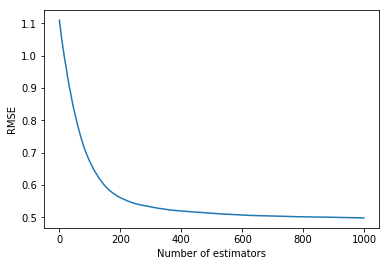

In [203]:
dict_val=xgb.evals_result()
plt.plot(dict_val['validation_0']['rmse'])
plt.ylabel('RMSE')
plt.xlabel('Number of estimators')
plt.show()

In [157]:
y_pred_train=xgb.predict(Xtrain)
y_pred_test=xgb.predict(Xtest)

In [159]:
print('r2 train : ',r2_score(ytrain,y_pred_train))
print('r2 test : ',r2_score(ytest,y_pred_test))

r2 train :  0.8122692205855276
r2 test :  0.7254554973033798


In [174]:
from sklearn.metrics import mean_squared_error
print('RMSE train : ',np.sqrt(mean_squared_error(scale(ytrain),scale(y_pred_train))))
print('RMSE test : ',np.sqrt(mean_squared_error(scale(ytest),scale(y_pred_test))))

RMSE train :  0.4430144893795227
RMSE test :  0.5099430623776262


/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data 

In [186]:
def rmsle(y_true, y_pred):
    return 'rmsle',np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))

In [168]:
print('RMSLE train : ',rmsle(ytrain,y_pred_train))
print('RMSLE test : ',rmsle(ytest,y_pred_test))

/Users/camilleruppli/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


RMSLE train :  0.38820360763276834
RMSLE test :  0.43816015492969207
